<a href="https://colab.research.google.com/github/Abigail6on/Apple-Health-Sleep-Analysis/blob/main/health_sleep_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sleep Data Analysis

This notebook performs an exploratory data analysis on sleep data exported from Apple Health.

# 1. Data Loading and Initial Inspection

In [111]:
import pandas as pd
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [112]:
records = []
for event, element in ET.iterparse('/content/export.xml', events=("start",)):
    if element.tag == "Record":
        records.append(element.attrib)

df = pd.DataFrame(records)

# 2. Data Cleaning

Check missing values

In [113]:
sleep_df = df[df['type'] == 'HKCategoryTypeIdentifierSleepAnalysis'].copy()
# Keep entries for 'Asleep', '1', or 'In Bed'
sleep_df = sleep_df[sleep_df['value'].str.contains('Asleep|1|HKCategoryValueSleepAnalysisInBed', na=False)]

sleep_df.isna().sum()

,0
type,0
sourceName,0
sourceVersion,179
unit,15874
creationDate,0
startDate,0
endDate,0
value,0
device,15695


In [114]:
# Drop columns with a high number of missing values and those not used in analysis
sleep_df.drop(columns=['sourceVersion', 'unit', 'device'], inplace=True)

# 3. Exploratory Data Analysis (EDA)

### Sleep Stage Analysis (2024 onward)

In [115]:
# Filter for data from 2024 onwards and from Apple Watch

# Convert 'startDate' and 'endDate' to datetime objects
sleep_df['startDate'] = pd.to_datetime(sleep_df['startDate'])
sleep_df['endDate'] = pd.to_datetime(sleep_df['endDate'])

apple_watch_sleep_df = sleep_df[(sleep_df['startDate'].dt.year >= 2024) & (sleep_df['sourceName'] == 'Ellen’s Apple Watch')].copy()

# Display info of the filtered DataFrame
display(apple_watch_sleep_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 12104 entries, 1014675 to 1031851
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype                    
---  ------        --------------  -----                    
 0   type          12104 non-null  object                   
 1   sourceName    12104 non-null  object                   
 2   creationDate  12104 non-null  object                   
 3   startDate     12104 non-null  datetime64[ns, UTC-04:00]
 4   endDate       12104 non-null  datetime64[ns, UTC-04:00]
 5   value         12104 non-null  object                   
dtypes: datetime64[ns, UTC-04:00](2), object(4)
memory usage: 661.9+ KB


None

In [116]:
# Calculate the duration of each sleep stage
apple_watch_sleep_df['duration'] = (apple_watch_sleep_df['endDate'] - apple_watch_sleep_df['startDate']).dt.total_seconds() / 60
apple_watch_sleep_df['duration_hour'] = apple_watch_sleep_df['duration'] / 60

# Group by sleep stage and calculate the average of the durations
sleep_stage_durations = apple_watch_sleep_df.groupby('value')['duration'].mean().sort_values(ascending=False)

display(sleep_stage_durations)

,duration
value,
HKCategoryValueSleepAnalysisInBed,39.944416
HKCategoryValueSleepAnalysisAsleepUnspecified,27.876344
HKCategoryValueSleepAnalysisAsleepCore,20.868298
HKCategoryValueSleepAnalysisAsleepREM,16.452214
HKCategoryValueSleepAnalysisAsleepDeep,9.366383


In [117]:
# Filter out 'HKCategoryValueSleepAnalysisInBed'
sleep_awake_df = apple_watch_sleep_df[apple_watch_sleep_df['value'] != 'HKCategoryValueSleepAnalysisInBed'].copy()

# Group by the date and sum the duration in hours for each night, excluding 'In Bed' time
daily_sleep_summary_excluding_inbed = sleep_awake_df.groupby(sleep_awake_df['startDate'].dt.date)['duration_hour'].sum()

# Convert the index to datetime for easier plotting later
daily_sleep_summary_excluding_inbed.index = pd.to_datetime(daily_sleep_summary_excluding_inbed.index)

display(daily_sleep_summary_excluding_inbed.head())

,duration_hour
startDate,
2024-02-17,9.433333
2024-02-18,7.200000
2024-02-19,8.450000
2024-02-20,8.591667
2024-02-21,8.058333


In [118]:
# Extract month and year
apple_watch_sleep_df['year_month'] = apple_watch_sleep_df['startDate'].dt.to_period('M')

# Group by date and sleep stage, sum the duration to get total duration per stage per night
daily_sleep_stage_total_duration = apple_watch_sleep_df.groupby([apple_watch_sleep_df['startDate'].dt.date, 'value'])['duration_hour'].sum().unstack()

daily_sleep_stage_total_duration.index = pd.to_datetime(daily_sleep_stage_total_duration.index)
monthly_sleep_stage_duration = daily_sleep_stage_total_duration.groupby(daily_sleep_stage_total_duration.index.to_period('M')).mean()

display(monthly_sleep_stage_duration.head())

/tmp/ipython-input-3920513363.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  apple_watch_sleep_df['year_month'] = apple_watch_sleep_df['startDate'].dt.to_period('M')


value,HKCategoryValueSleepAnalysisAsleepCore,HKCategoryValueSleepAnalysisAsleepDeep,HKCategoryValueSleepAnalysisAsleepREM,HKCategoryValueSleepAnalysisAsleepUnspecified,HKCategoryValueSleepAnalysisInBed
startDate,,,,,
2024-02,6.216667,0.486538,1.694872,NaN,8.398077
2024-03,6.162097,0.486494,1.473118,NaN,8.090323
2024-04,6.227222,0.487931,1.580278,NaN,8.279167
2024-05,5.882527,0.485000,1.586022,NaN,7.937903
2024-06,5.770556,0.522917,1.452679,NaN,7.614444


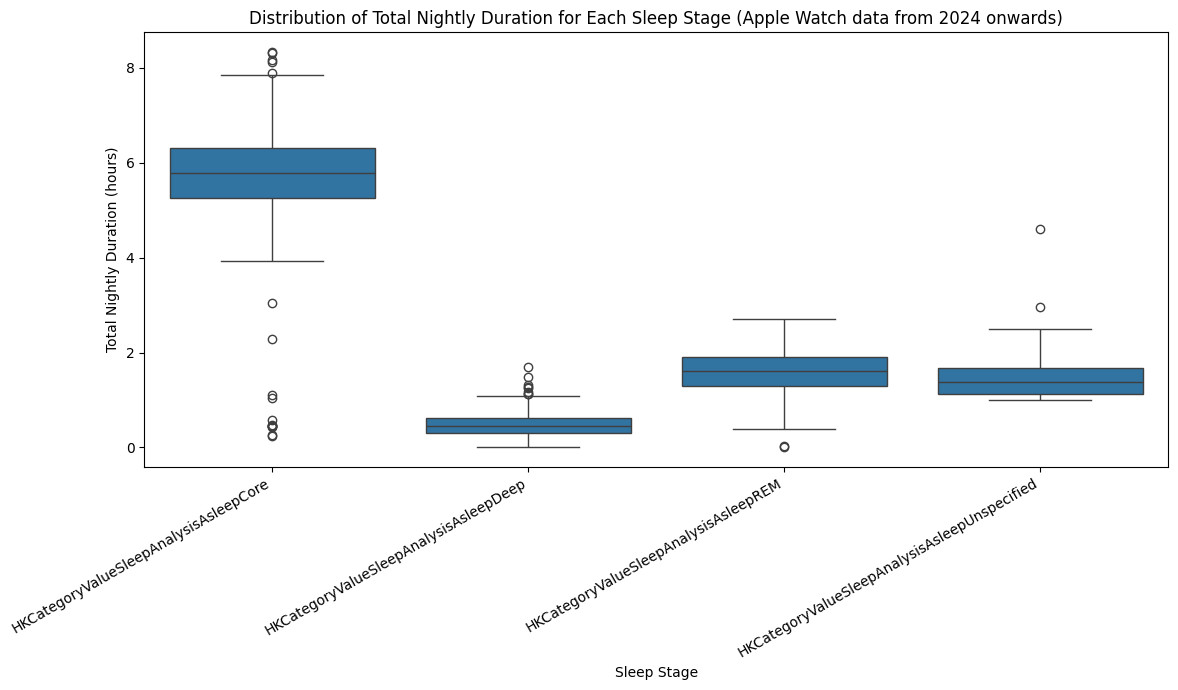

In [119]:
# The daily_sleep_stage_total_duration DataFrame already contains the total duration for each sleep stage per night.
daily_sleep_stage_total_duration_melted = daily_sleep_stage_total_duration.reset_index().melt(
    id_vars='startDate', var_name='Sleep Stage', value_name='Total Nightly Duration (hours)'
)

# Filter out the 'In Bed' stage if you only want to see the actual sleep stages in this plot
daily_sleep_stage_total_duration_melted = daily_sleep_stage_total_duration_melted[
    daily_sleep_stage_total_duration_melted['Sleep Stage'] != 'HKCategoryValueSleepAnalysisInBed'
]

plt.figure(figsize=(12, 7))
sns.boxplot(x='Sleep Stage', y='Total Nightly Duration (hours)', data=daily_sleep_stage_total_duration_melted)
plt.title('Distribution of Total Nightly Duration for Each Sleep Stage (Apple Watch data from 2024 onwards)')
plt.xlabel('Sleep Stage')
plt.ylabel('Total Nightly Duration (hours)')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

## Handle outliers

In [120]:
# Calculate Q1, Q3, and IQR for daily sleep duration
Q1 = daily_sleep_summary_excluding_inbed.quantile(0.25)
Q3 = daily_sleep_summary_excluding_inbed.quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = daily_sleep_summary_excluding_inbed[
    (daily_sleep_summary_excluding_inbed < lower_bound) | (daily_sleep_summary_excluding_inbed > upper_bound)]

print("Identified Outliers (Daily Sleep Duration):")
display(outliers)

# Create a new Series excluding outliers
daily_sleep_summary_no_outliers = daily_sleep_summary_excluding_inbed[
    (daily_sleep_summary_excluding_inbed >= lower_bound) & (daily_sleep_summary_excluding_inbed <= upper_bound)]

print("\nDaily Sleep Summary excluding Outliers (first 5 rows):")
display(daily_sleep_summary_no_outliers.head())

daily_sleep_summary_excluding_inbed = daily_sleep_summary_no_outliers

Identified Outliers (Daily Sleep Duration):


,duration_hour
startDate,
2024-06-14,0.441667
2024-06-17,0.441667
2024-07-11,0.458333
2024-07-19,0.633333
2024-07-31,0.475000
2024-08-02,1.041667
2024-09-07,0.583333
2024-09-18,0.708333
2024-11-05,1.433333



Daily Sleep Summary excluding Outliers (first 5 rows):


,duration_hour
startDate,
2024-02-17,9.433333
2024-02-18,7.200000
2024-02-19,8.450000
2024-02-20,8.591667
2024-02-21,8.058333


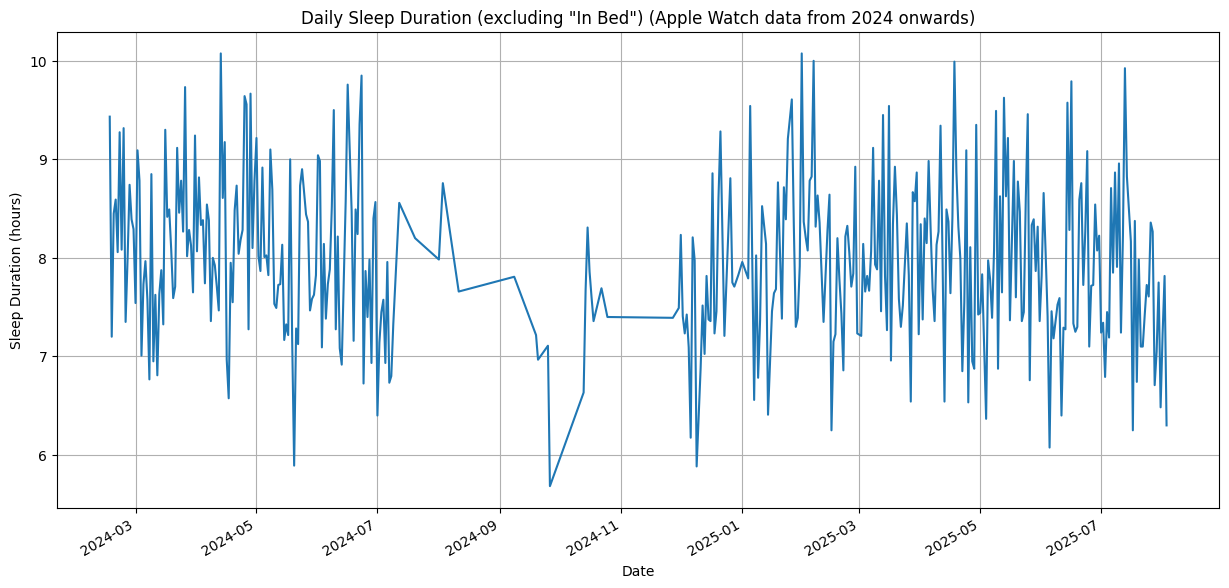

In [121]:
plt.figure(figsize=(15, 7))
daily_sleep_summary_excluding_inbed.plot()
plt.title('Daily Sleep Duration (excluding "In Bed") (Apple Watch data from 2024 onwards)')
plt.xlabel('Date')
plt.ylabel('Sleep Duration (hours)')
plt.grid(True)
plt.show()

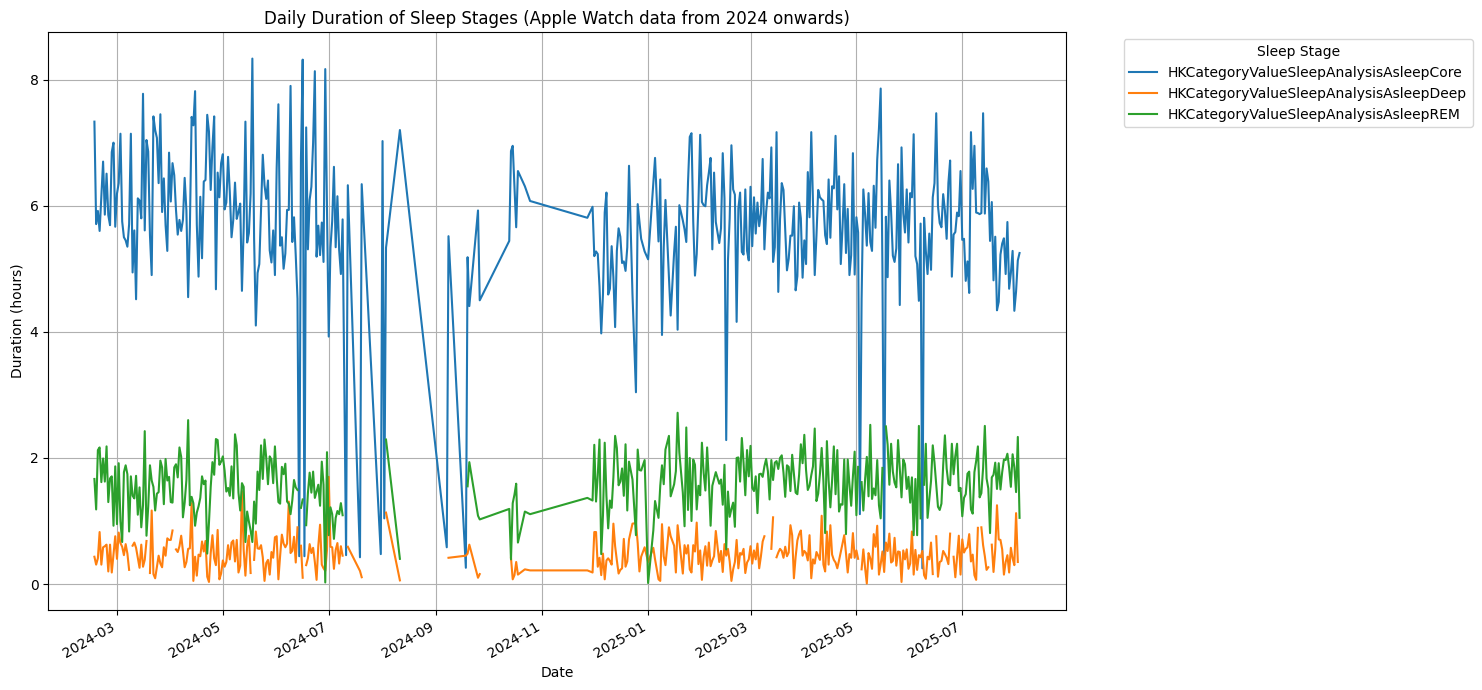

In [122]:
# Define the sleep stages of interest
sleep_stages_of_interest = [
    'HKCategoryValueSleepAnalysisAsleepCore',
    'HKCategoryValueSleepAnalysisAsleepREM',
    'HKCategoryValueSleepAnalysisAsleepDeep',
    'HKCategoryValueSleepAnalysisAwake'
]

# Filter the DataFrame to include only the sleep stages of interest
filtered_sleep_stages_df = apple_watch_sleep_df[apple_watch_sleep_df['value'].isin(sleep_stages_of_interest)].copy()

daily_sleep_stage_duration = filtered_sleep_stages_df.groupby([filtered_sleep_stages_df['startDate'].dt.date, 'value'])['duration_hour'].sum().unstack()

daily_sleep_stage_duration.index = pd.to_datetime(daily_sleep_stage_duration.index)

# Plot the daily duration of each sleep stage
plt.figure(figsize=(15, 7))
daily_sleep_stage_duration.plot(ax=plt.gca())
plt.title('Daily Duration of Sleep Stages (Apple Watch data from 2024 onwards)')
plt.xlabel('Date')
plt.ylabel('Duration (hours)')
plt.legend(title='Sleep Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

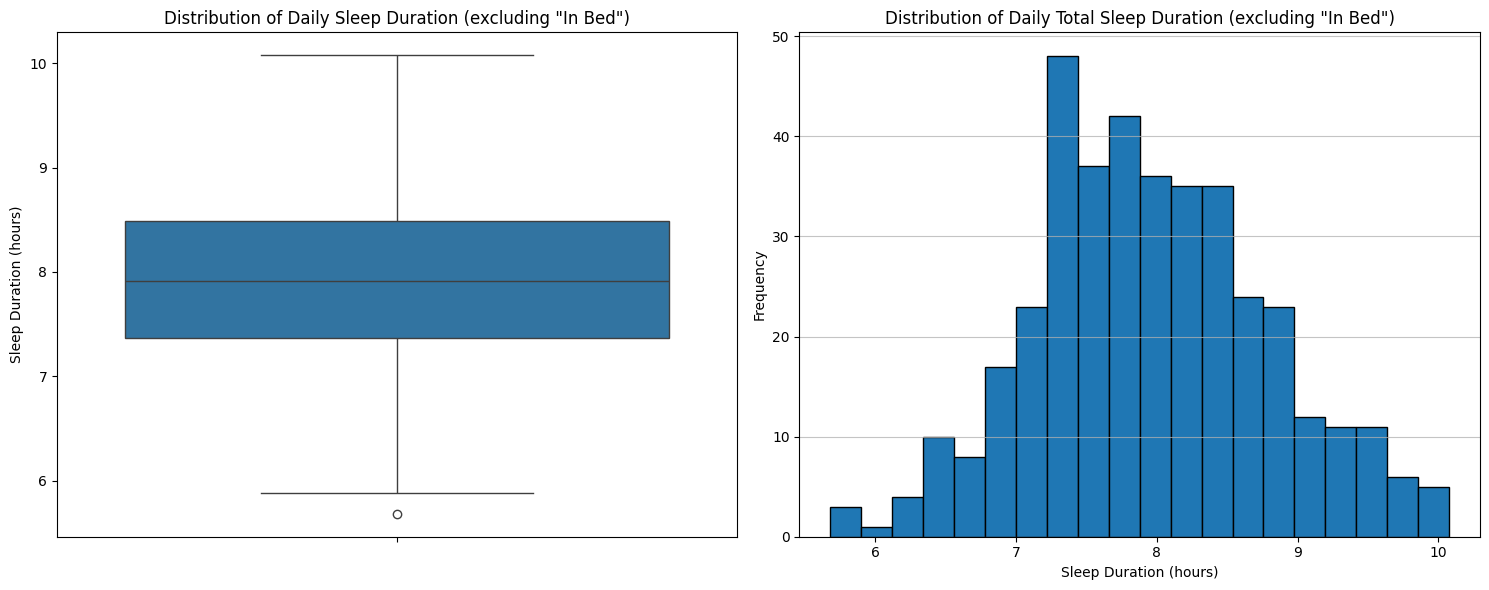

In [123]:
# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the box plot on the first subplot
sns.boxplot(y=daily_sleep_summary_excluding_inbed, ax=axes[0])
axes[0].set_title('Distribution of Daily Sleep Duration (excluding "In Bed")')
axes[0].set_ylabel('Sleep Duration (hours)')

# Plot the histogram on the second subplot
axes[1].hist(daily_sleep_summary_excluding_inbed, bins=20, edgecolor='black')
axes[1].set_title('Distribution of Daily Total Sleep Duration (excluding "In Bed")')
axes[1].set_xlabel('Sleep Duration (hours)')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

In [124]:
# Filter the DataFrame to show only records from 'Ellen’s Apple Watch'
apple_watch_all_sleep_df = sleep_df[sleep_df['sourceName'] == 'Ellen’s Apple\xa0Watch'].copy()

# Display info of the filtered DataFrame
display(apple_watch_all_sleep_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 12104 entries, 1014675 to 1031851
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype                    
---  ------        --------------  -----                    
 0   type          12104 non-null  object                   
 1   sourceName    12104 non-null  object                   
 2   creationDate  12104 non-null  object                   
 3   startDate     12104 non-null  datetime64[ns, UTC-04:00]
 4   endDate       12104 non-null  datetime64[ns, UTC-04:00]
 5   value         12104 non-null  object                   
dtypes: datetime64[ns, UTC-04:00](2), object(4)
memory usage: 661.9+ KB


None

In [125]:
# Analyze the distribution of sleep stages in the full Apple Watch data
apple_watch_sleep_stage_counts = apple_watch_all_sleep_df['value'].value_counts()
display(apple_watch_sleep_stage_counts)

,count
value,
HKCategoryValueSleepAnalysisAsleepCore,6621
HKCategoryValueSleepAnalysisAsleepREM,2281
HKCategoryValueSleepAnalysisInBed,1934
HKCategoryValueSleepAnalysisAsleepDeep,1175
HKCategoryValueSleepAnalysisAsleepUnspecified,93


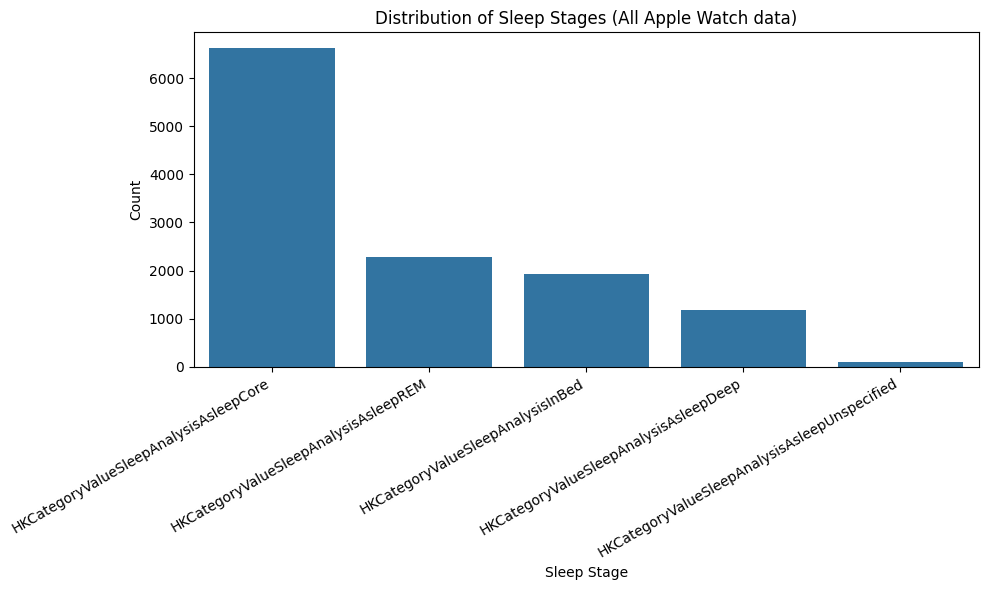

In [126]:
plt.figure(figsize=(10, 6))
sns.barplot(x=apple_watch_sleep_stage_counts.index, y=apple_watch_sleep_stage_counts.values)
plt.title('Distribution of Sleep Stages (All Apple Watch data)')
plt.xlabel('Sleep Stage')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

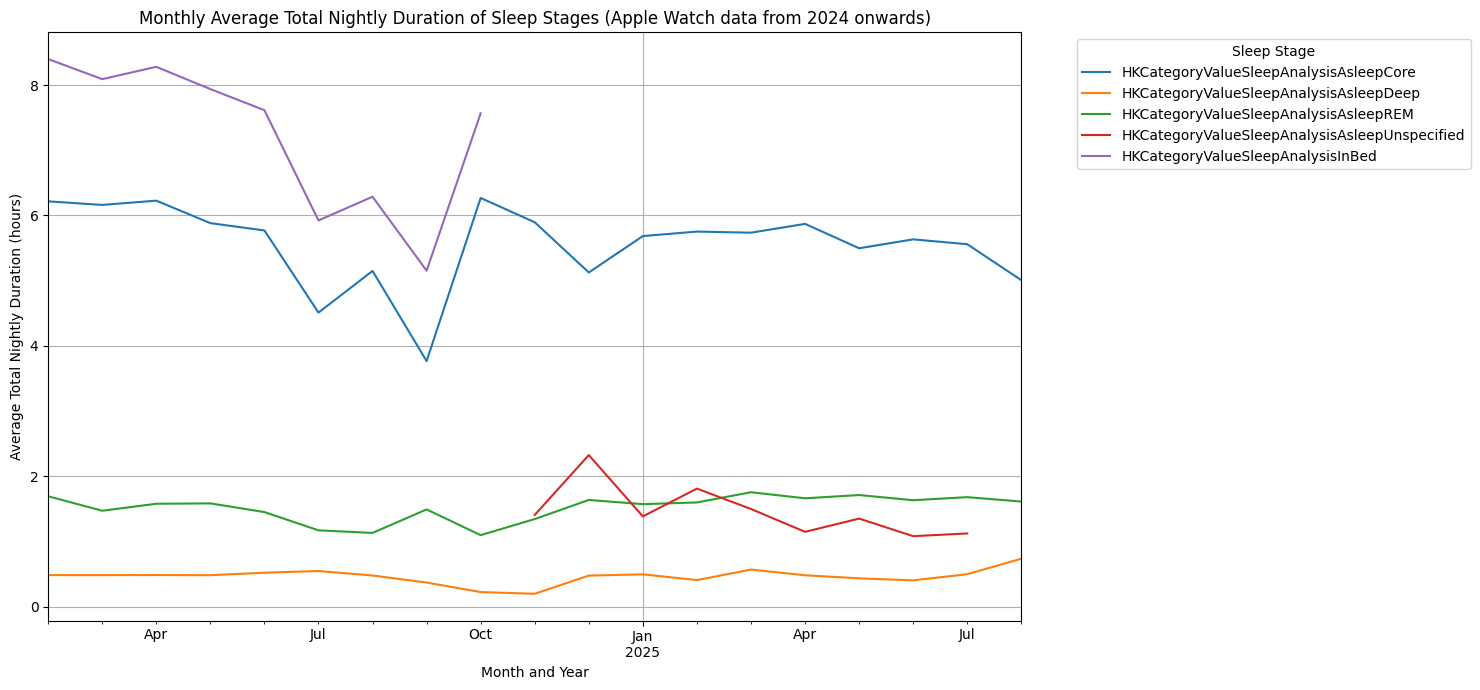

In [127]:
# Plot the monthly average duration of each sleep stage
plt.figure(figsize=(15, 7))
monthly_sleep_stage_duration.plot(ax=plt.gca())
plt.title('Monthly Average Total Nightly Duration of Sleep Stages (Apple Watch data from 2024 onwards)')
plt.xlabel('Month and Year')
plt.ylabel('Average Total Nightly Duration (hours)')
plt.legend(title='Sleep Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## Analyse sleeping time accoding to different seasons

In [128]:
# Define summer and winter months
summer_months = [6, 7, 8]  # June, July, August
winter_months = [12, 1, 2]  # December, January, February

# Extract the month from the startDate
apple_watch_sleep_df['month'] = apple_watch_sleep_df['startDate'].dt.month

# Categorize each record into 'Summer', 'Winter', or 'Other'
def categorize_season(month):
    if month in summer_months:
        return 'Summer'
    elif month in winter_months:
        return 'Winter'
    else:
        return 'Other'

apple_watch_sleep_df['season'] = apple_watch_sleep_df['month'].apply(categorize_season)

# Filter for Summer and Winter seasons BEFORE grouping
seasonal_sleep_df = apple_watch_sleep_df[apple_watch_sleep_df['season'].isin(['Summer', 'Winter'])].copy()

# Group by date and sleep stage, sum the duration to get total duration per stage per night
daily_sleep_stage_total_duration_seasonal = seasonal_sleep_df.groupby([seasonal_sleep_df['startDate'].dt.date,
                                                                       'value'])['duration_hour'].sum().unstack()

# Convert the index to datetime
daily_sleep_stage_total_duration_seasonal.index = pd.to_datetime(daily_sleep_stage_total_duration_seasonal.index)

# Add the season back as a column for grouping by season
daily_sleep_stage_total_duration_seasonal['season'] = daily_sleep_stage_total_duration_seasonal.index.month.map(categorize_season)

# Calculate the mean duration per sleep stage for each season
seasonal_sleep_stage_duration = daily_sleep_stage_total_duration_seasonal.groupby('season').mean()

display(seasonal_sleep_stage_duration)

value,HKCategoryValueSleepAnalysisAsleepCore,HKCategoryValueSleepAnalysisAsleepDeep,HKCategoryValueSleepAnalysisAsleepREM,HKCategoryValueSleepAnalysisAsleepUnspecified,HKCategoryValueSleepAnalysisInBed
season,,,,,
Summer,5.475446,0.490441,1.536587,1.104167,7.010764
Winter,5.615942,0.464855,1.617844,1.763235,8.398077


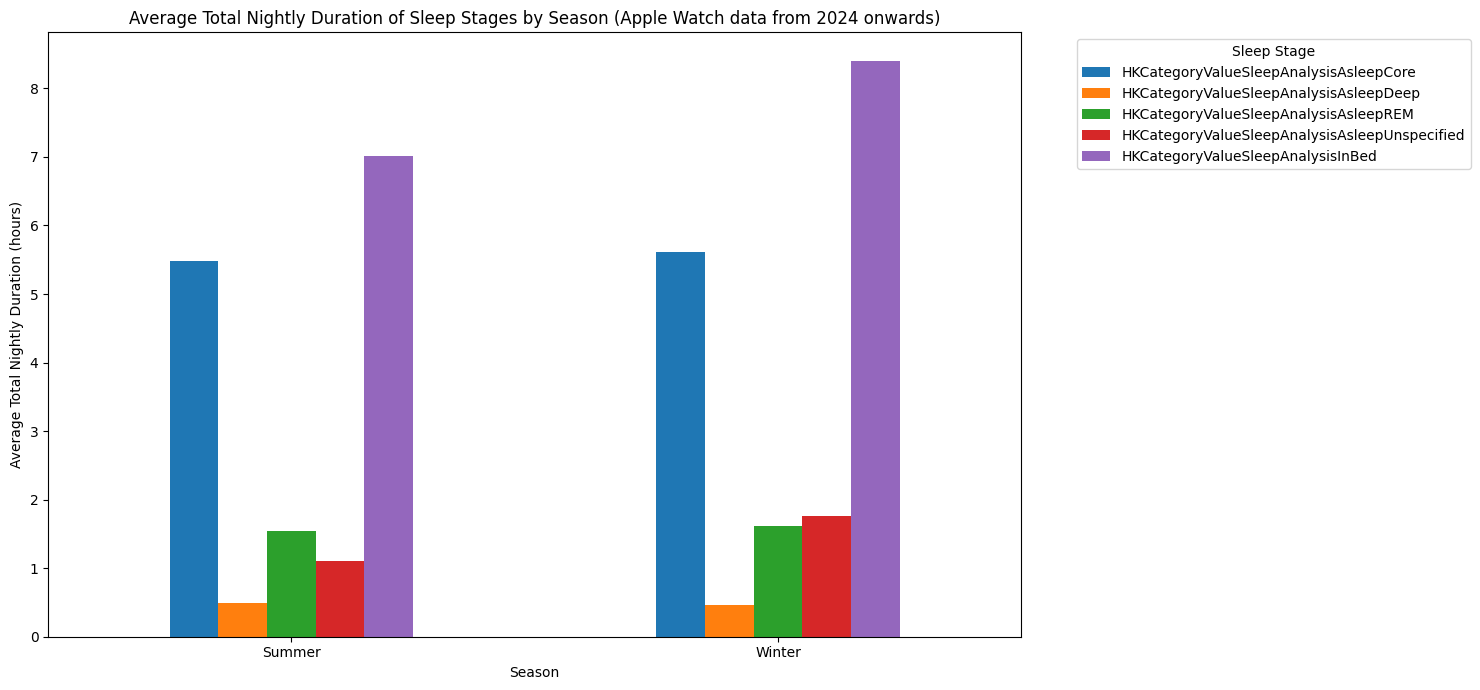

In [129]:
seasonal_sleep_stage_duration.plot(kind='bar', figsize=(15, 7))
plt.title('Average Total Nightly Duration of Sleep Stages by Season (Apple Watch data from 2024 onwards)')
plt.xlabel('Season')
plt.ylabel('Average Total Nightly Duration (hours)')
plt.xticks(rotation=0)
plt.legend(title='Sleep Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Seems like I spend more time in bed in winter.

In [130]:
# Filter for 'In Bed' records to get approximate bedtime and wake-up times
in_bed_df = apple_watch_sleep_df[apple_watch_sleep_df['value'] == 'HKCategoryValueSleepAnalysisInBed'].copy()

# Extract the time component from startDate (bedtime) and endDate (wake-up time)
in_bed_df['bedtime'] = in_bed_df['startDate'].dt.time
in_bed_df['wake_up_time'] = in_bed_df['endDate'].dt.time

# Display the first few rows with the new time columns
# display(in_bed_df.head())

In [131]:
# Convert time objects to a format that allows for easier calculation of statistics if needed later
# For now, we can focus on visualizing the distribution of times directly.

# Display descriptive statistics for bedtime and wake-up time
# We can visualize the distribution to understand consistency.

print("Bedtime Distribution (first 5):")
display(in_bed_df['bedtime'].head())

print("\nWake-up Time Distribution (first 5):")
display(in_bed_df['wake_up_time'].head())

# To get a sense of the range, we can sort the times
print("\nEarliest Bedtime:")
display(in_bed_df['bedtime'].min())

print("\nLatest Bedtime:")
display(in_bed_df['bedtime'].max())

print("\nEarliest Wake-up Time:")
display(in_bed_df['wake_up_time'].min())

print("\nLatest Wake-up Time:")
display(in_bed_df['wake_up_time'].max())

Bedtime Distribution (first 5):


,bedtime
1014677,00:08:28
1014680,00:46:28
1014686,01:10:28
1014689,02:36:58
1014692,03:08:58



Wake-up Time Distribution (first 5):


,wake_up_time
1014677,00:45:28
1014680,01:09:58
1014686,02:35:28
1014689,03:06:58
1014692,03:22:58



Earliest Bedtime:


datetime.time(0, 0, 12)


Latest Bedtime:


datetime.time(23, 59, 58)


Earliest Wake-up Time:


datetime.time(0, 0, 9)


Latest Wake-up Time:


datetime.time(23, 59, 39)

In [132]:
# Group 'In Bed' records by date and sum the duration to get the total 'In Bed' duration per night
daily_in_bed_duration = in_bed_df.groupby(in_bed_df['startDate'].dt.date)['duration_hour'].sum()

# Convert the index to datetime for easier handling
daily_in_bed_duration.index = pd.to_datetime(daily_in_bed_duration.index)

# Add day of week and day type (weekday/weekend) to this daily summary
daily_in_bed_duration_df = daily_in_bed_duration.reset_index()
daily_in_bed_duration_df.columns = ['date', 'total_in_bed_duration_hour']
daily_in_bed_duration_df['day_of_week'] = daily_in_bed_duration_df['date'].dt.dayofweek
daily_in_bed_duration_df['day_type'] = daily_in_bed_duration_df['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Calculate the average total 'In Bed' duration for weekdays vs weekends
average_total_in_bed_duration_by_day_type = daily_in_bed_duration_df.groupby('day_type')['total_in_bed_duration_hour'].mean()

display(average_total_in_bed_duration_by_day_type)

,total_in_bed_duration_hour
day_type,
Weekday,7.437639
Weekend,8.229687


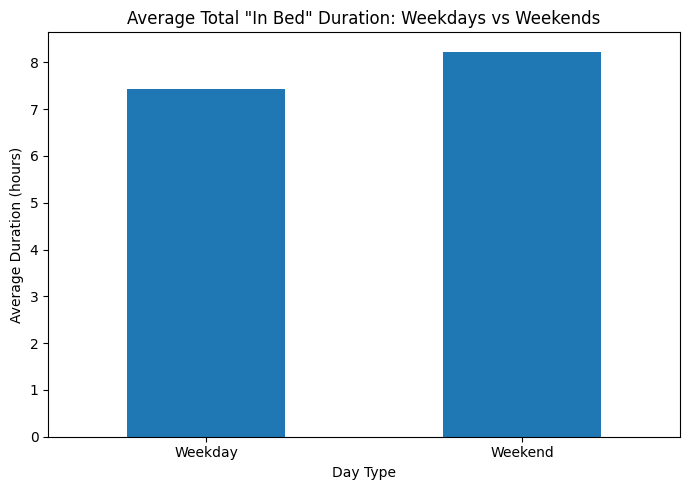

In [133]:
# Plot the average total 'In Bed' duration for weekdays vs weekends
plt.figure(figsize=(7, 5))
average_total_in_bed_duration_by_day_type.plot(kind='bar')
plt.title('Average Total "In Bed" Duration: Weekdays vs Weekends')
plt.xlabel('Day Type')
plt.ylabel('Average Duration (hours)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [134]:
# Filter for Deep and REM sleep stages
deep_rem_sleep_df = apple_watch_sleep_df[
    apple_watch_sleep_df['value'].isin(['HKCategoryValueSleepAnalysisAsleepDeep', 'HKCategoryValueSleepAnalysisAsleepREM'])
].copy()

# Extract the time component of the start time
deep_rem_sleep_df['start_time'] = deep_rem_sleep_df['startDate'].dt.time

# Ensure 'start_time' column is created by extracting time from startDate
deep_rem_sleep_df['start_time'] = deep_rem_sleep_df['startDate'].dt.time

# Convert time objects to seconds since midnight for plotting
deep_rem_sleep_df['start_time_seconds'] = deep_rem_sleep_df['start_time'].apply(lambda t: t.hour * 3600 + t.minute * 60 + t.second)

# Adjust times to represent a timeline spanning across midnight
# Using the same start_of_night_seconds as the bedtime plot for consistency
start_of_night_seconds = 18 * 3600
deep_rem_sleep_df['start_time_seconds_shifted'] = (deep_rem_sleep_df['start_time_seconds'] - start_of_night_seconds) % (24 * 3600)

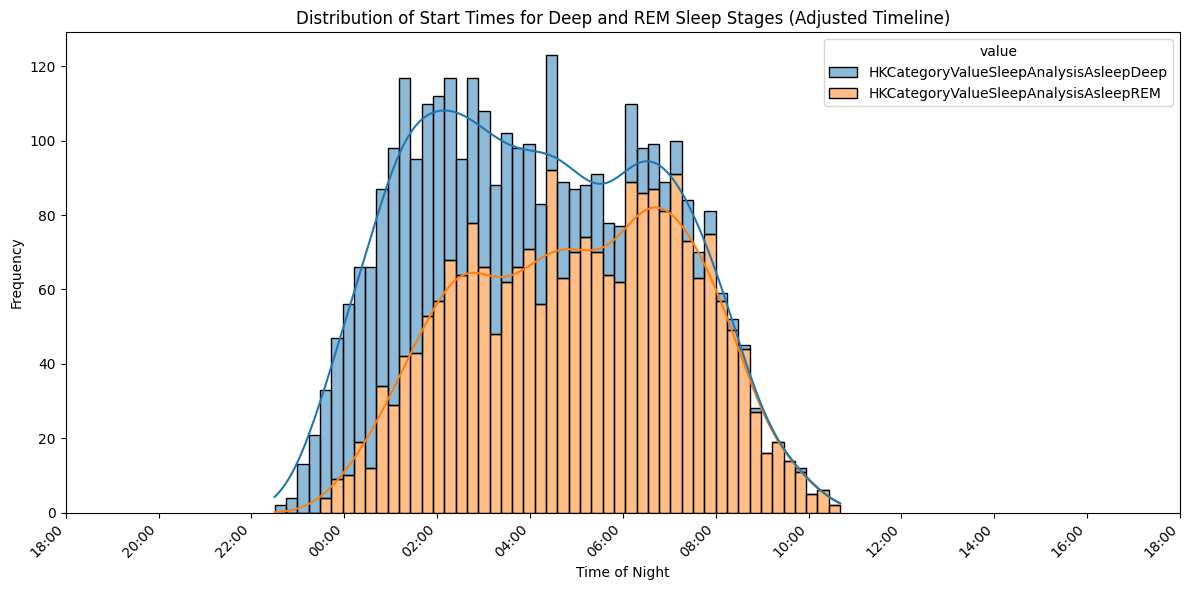

In [135]:
plt.figure(figsize=(12, 6))
sns.histplot(data=deep_rem_sleep_df, x='start_time_seconds_shifted', hue='value', multiple='stack', bins=50, kde=True)

# Improve x-axis labels by converting shifted seconds back to a time format
# Use the same tick locations and labels as the adjusted bedtime plot for consistency
max_shifted_seconds = deep_rem_sleep_df['start_time_seconds_shifted'].max()
tick_interval_seconds = 2 * 3600
tick_locations_shifted = np.arange(0, 24 * 3600 + tick_interval_seconds, tick_interval_seconds)
tick_labels_shifted = [f'{int(((s + start_of_night_seconds) % (24 * 3600)) // 3600):02d}:{((s + start_of_night_seconds) % 3600) // 60:02d}' for s in tick_locations_shifted]

plt.xticks(tick_locations_shifted, tick_labels_shifted, rotation=45, ha='right')

plt.title('Distribution of Start Times for Deep and REM Sleep Stages (Adjusted Timeline)')
plt.xlabel('Time of Night')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

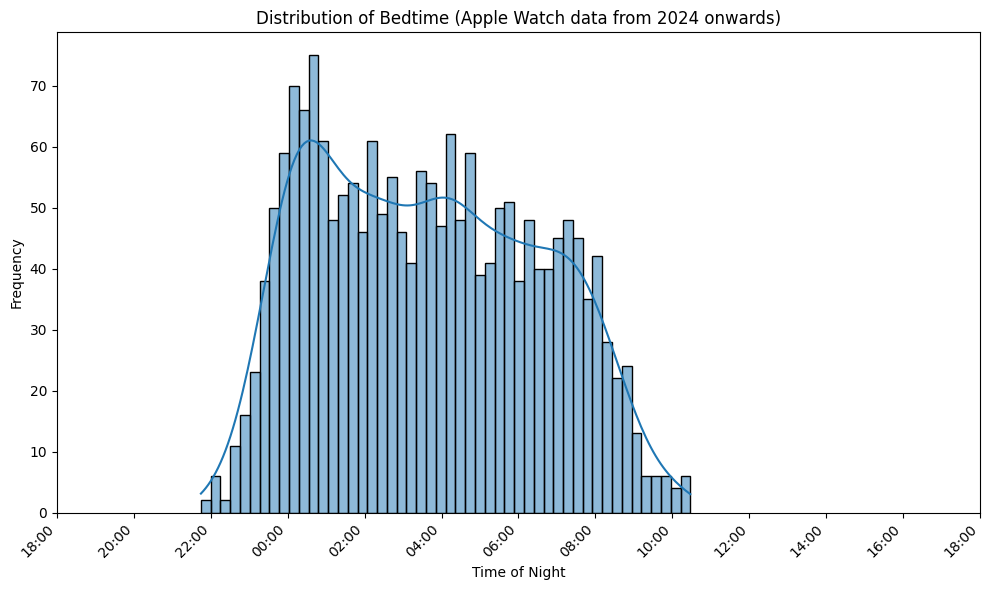

In [136]:
# Convert bedtime to seconds since midnight for plotting
in_bed_df['bedtime_seconds'] = in_bed_df['bedtime'].apply(lambda t: t.hour * 3600 + t.minute * 60 + t.second)

# Adjust times that are after midnight by adding 24 hours worth of seconds
# This makes the timeline flow from evening into the next morning
in_bed_df['bedtime_seconds_adjusted'] = in_bed_df['bedtime_seconds'].apply(lambda x: x if x < 12 * 3600 else x - 24 * 3600)
# A better approach is to shift the entire timeline so that midnight is not at the beginning or end.
# Let's set the start of our "night" at 6 PM (18:00)
start_of_night_seconds = 18 * 3600
in_bed_df['bedtime_seconds_shifted'] = (in_bed_df['bedtime_seconds'] - start_of_night_seconds) % (24 * 3600)

plt.figure(figsize=(10, 6))
sns.histplot(data=in_bed_df, x='bedtime_seconds_shifted', bins=50, kde=True)

# Improve x-axis labels by converting shifted seconds back to a time format
max_shifted_seconds = in_bed_df['bedtime_seconds_shifted'].max()
# Generate tick locations at reasonable intervals (e.g., every 2 hours)
# The tick locations should be based on the shifted time scale
tick_interval_seconds = 2 * 3600
# Start ticks from the beginning of the shifted timeline or a bit before, up to the end
tick_locations_shifted = np.arange(0, 24 * 3600 + tick_interval_seconds, tick_interval_seconds)

# Generate corresponding time labels, converting shifted seconds back to standard time
# We need to add the start_of_night_seconds back and take modulo 24 hours to get the correct time
tick_labels_shifted = [f'{int(((s + start_of_night_seconds) % (24 * 3600)) // 3600):02d}:{((s + start_of_night_seconds) % 3600) // 60:02d}' for s in tick_locations_shifted]

plt.xticks(tick_locations_shifted, tick_labels_shifted, rotation=45, ha='right')
plt.title('Distribution of Bedtime (Apple Watch data from 2024 onwards)')
plt.xlabel('Time of Night')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## 5. Summary of Findings

Based on the exploratory data analysis of my Apple Watch sleep data from 2024 onwards, here is a summary of the key findings:

*   **Sleep Stage Distribution:** The analysis of my sleep stage counts and average *total nightly* durations shows the proportion of time I spent in different sleep stages (Core, REM, Deep, Awake, In Bed). I observed the average *total nightly* duration for each stage, with 'In Bed' typically having the longest average duration, followed by Core, REM, Deep, and Awake.
*   **Daily Sleep Duration:** Visualizing my daily total sleep duration (excluding 'In Bed') revealed the overall trend and variability in my sleep time from night to night.
*   **Outlier Detection:** The box plot and histogram of my daily sleep duration helped in understanding the distribution of my sleep times and identifying potential outliers, which represent unusually short or long sleep nights for me.
*   **Monthly and Seasonal Patterns:** Analyzing the monthly average *total nightly* duration of my sleep stages and comparing my sleep patterns between summer and winter provided insights into potential seasonal influences on my sleep. Notably, I tend to spend more total time in bed during the winter months compared to summer.
*   **Weekday vs. Weekend "In Bed" Duration:** I found that I spend more total time in bed on weekends compared to weekdays.
*   **Sleep Consistency:** Visualizing the distribution of my bedtime with an adjusted timeline showed the consistency of my sleep starting times.
*   **Timing of Sleep Stages:** The adjusted timeline histograms for Deep and REM sleep start times illustrated when these crucial sleep stages typically began during my sleep sessions.

These findings provide a good foundation for understanding my sleep patterns and how they relate to other aspects of my health data. Further analysis could delve deeper into specific periods, investigate the identified outliers, or explore non-linear relationships between the factors, and incorporate other health metrics for correlation analysis.

# Statistical Significance Testing

Determine which statistical tests are suitable for comparing the sleep metrics (like duration or stage percentages) between the defined groups (seasons or day types).


## Prepare data for testing

Prepare data for testing by reshaping or filtering the data as needed to perform the chosen statistical tests. This might involve creating subsets of data for each group.


In [137]:
# Filter for Weekday and Weekend data
weekday_in_bed_duration = daily_in_bed_duration_df[daily_in_bed_duration_df['day_type'] == 'Weekday']['total_in_bed_duration_hour']
weekend_in_bed_duration = daily_in_bed_duration_df[daily_in_bed_duration_df['day_type'] == 'Weekend']['total_in_bed_duration_hour']

print("Weekday In Bed Duration (first 5):")
display(weekday_in_bed_duration.head())

print("\nWeekend In Bed Duration (first 5):")
display(weekend_in_bed_duration.head())

Weekday In Bed Duration (first 5):


,total_in_bed_duration_hour
2,8.450000
3,8.591667
4,8.058333
5,9.275000
6,8.083333



Weekend In Bed Duration (first 5):


,total_in_bed_duration_hour
0,9.433333
1,7.200000
7,9.316667
8,7.350000
14,9.091667


In [138]:
# Filter for Summer and Winter data
summer_sleep_stage_duration = daily_sleep_stage_total_duration_seasonal[daily_sleep_stage_total_duration_seasonal['season'] == 'Summer']
winter_sleep_stage_duration = daily_sleep_stage_total_duration_seasonal[daily_sleep_stage_total_duration_seasonal['season'] == 'Winter']

# Extract sleep stage duration columns for Summer and Winter
sleep_stages = [
    'HKCategoryValueSleepAnalysisAsleepCore',
    'HKCategoryValueSleepAnalysisAsleepDeep',
    'HKCategoryValueSleepAnalysisAsleepREM',
    'HKCategoryValueSleepAnalysisAsleepUnspecified',
    'HKCategoryValueSleepAnalysisInBed'
]

summer_sleep_stage_durations_series = summer_sleep_stage_duration[sleep_stages]
winter_sleep_stage_durations_series = winter_sleep_stage_duration[sleep_stages]

print("Summer Sleep Stage Durations (first 5):")
display(summer_sleep_stage_durations_series.head())

print("\nWinter Sleep Stage Durations (first 5):")
display(winter_sleep_stage_durations_series.head())

Summer Sleep Stage Durations (first 5):


value,HKCategoryValueSleepAnalysisAsleepCore,HKCategoryValueSleepAnalysisAsleepDeep,HKCategoryValueSleepAnalysisAsleepREM,HKCategoryValueSleepAnalysisAsleepUnspecified,HKCategoryValueSleepAnalysisInBed
startDate,,,,,
2024-06-01,6.591667,0.758333,1.691667,NaN,9.041667
2024-06-02,7.608333,0.075000,1.300000,NaN,9.025000
2024-06-03,5.366667,0.450000,1.275000,NaN,7.050000
2024-06-04,5.500000,0.783333,1.858333,NaN,8.141667
2024-06-05,5.000000,0.641667,1.741667,NaN,7.383333



Winter Sleep Stage Durations (first 5):


value,HKCategoryValueSleepAnalysisAsleepCore,HKCategoryValueSleepAnalysisAsleepDeep,HKCategoryValueSleepAnalysisAsleepREM,HKCategoryValueSleepAnalysisAsleepUnspecified,HKCategoryValueSleepAnalysisInBed
startDate,,,,,
2024-02-17,7.333333,0.433333,1.666667,NaN,9.433333
2024-02-18,5.708333,0.308333,1.183333,NaN,7.200000
2024-02-19,5.916667,0.408333,2.125000,NaN,8.450000
2024-02-20,5.600000,0.825000,2.166667,NaN,8.591667
2024-02-21,6.133333,0.308333,1.616667,NaN,8.058333


## Perform statistical tests


Implement the independent samples t-tests for weekday vs. weekend in-bed duration and for seasonal sleep stage durations, handling missing values in the seasonal comparison. Then print the results.



In [139]:
from scipy.stats import ttest_ind

# Perform independent samples t-test for weekday vs. weekend in-bed duration
t_stat_day_type, p_value_day_type = ttest_ind(
    weekday_in_bed_duration.dropna(),
    weekend_in_bed_duration.dropna()
)

# Perform independent samples t-test for seasonal sleep stage durations
seasonal_p_values = {}
sleep_stages = [
    'HKCategoryValueSleepAnalysisAsleepCore',
    'HKCategoryValueSleepAnalysisAsleepDeep',
    'HKCategoryValueSleepAnalysisAsleepREM',
    'HKCategoryValueSleepAnalysisAsleepUnspecified',
    'HKCategoryValueSleepAnalysisInBed'
]

for stage in sleep_stages:
    # Drop NaNs for each stage before performing the t-test
    summer_data = summer_sleep_stage_durations_series[stage].dropna()
    winter_data = winter_sleep_stage_durations_series[stage].dropna()

    # Perform t-test only if both groups have data
    if len(summer_data) > 1 and len(winter_data) > 1:
        t_stat_seasonal, p_value_seasonal = ttest_ind(
            summer_data,
            winter_data
        )
        seasonal_p_values[stage] = p_value_seasonal
    else:
        seasonal_p_values[stage] = np.nan  # Set p-value to NaN if either group has less than 2 data points


print("Independent Samples t-test: Weekday vs. Weekend In Bed Duration")
print(f"T-statistic: {t_stat_day_type:.4f}")
print(f"P-value: {p_value_day_type:.4f}")

print("\nIndependent Samples t-test P-values: Summer vs. Winter Sleep Stage Durations")
for stage, p_value in seasonal_p_values.items():
    if not np.isnan(p_value):
        print(f"{stage}: {p_value:.4f}")
    else:
        print(f"{stage}: Not enough data to perform test")

Independent Samples t-test: Weekday vs. Weekend In Bed Duration
T-statistic: -2.7151
P-value: 0.0073

Independent Samples t-test P-values: Summer vs. Winter Sleep Stage Durations
HKCategoryValueSleepAnalysisAsleepCore: 0.4411
HKCategoryValueSleepAnalysisAsleepDeep: 0.5074
HKCategoryValueSleepAnalysisAsleepREM: 0.2243
HKCategoryValueSleepAnalysisAsleepUnspecified: 0.3479
HKCategoryValueSleepAnalysisInBed: 0.0487


## Interpret results


Analyze the output of the statistical tests to draw conclusions about the significance of the observed differences.



In [140]:
# Significance level
alpha = 0.05

# Analyze weekday vs. weekend in-bed duration test result
print("Analysis of Weekday vs. Weekend In Bed Duration:")
print(f"P-value: {p_value_day_type:.4f}")
if p_value_day_type < alpha:
    print("Conclusion: There is a statistically significant difference in the average total in-bed duration between weekdays and weekends.")
else:
    print("Conclusion: There is no statistically significant difference in the average total in-bed duration between weekdays and weekends.")

# Analyze seasonal sleep stage duration test results
print("\nAnalysis of Summer vs. Winter Sleep Stage Durations:")
for stage, p_value in seasonal_p_values.items():
    if not np.isnan(p_value):
        print(f"\nSleep Stage: {stage}")
        print(f"P-value: {p_value:.4f}")
        if p_value < alpha:
            print("Conclusion: There is a statistically significant difference in the average duration of this sleep stage between summer and winter.")
        elif p_value >= alpha and p_value < 0.10:
            print("Conclusion: The p-value is close to the significance level (0.05-0.10), suggesting a potential trend that warrants further investigation.")
        else:
            print("Conclusion: There is no statistically significant difference in the average duration of this sleep stage between summer and winter.")
    else:
        print(f"\nSleep Stage: {stage}")
        print("Conclusion: Not enough data to perform test.")


Analysis of Weekday vs. Weekend In Bed Duration:
P-value: 0.0073
Conclusion: There is a statistically significant difference in the average total in-bed duration between weekdays and weekends.

Analysis of Summer vs. Winter Sleep Stage Durations:

Sleep Stage: HKCategoryValueSleepAnalysisAsleepCore
P-value: 0.4411
Conclusion: There is no statistically significant difference in the average duration of this sleep stage between summer and winter.

Sleep Stage: HKCategoryValueSleepAnalysisAsleepDeep
P-value: 0.5074
Conclusion: There is no statistically significant difference in the average duration of this sleep stage between summer and winter.

Sleep Stage: HKCategoryValueSleepAnalysisAsleepREM
P-value: 0.2243
Conclusion: There is no statistically significant difference in the average duration of this sleep stage between summer and winter.

Sleep Stage: HKCategoryValueSleepAnalysisAsleepUnspecified
P-value: 0.3479
Conclusion: There is no statistically significant difference in the average

## Summary of Statistical Findings:

Based on the independent samples t-tests performed:

*   **Weekday vs. Weekend In Bed Duration:** There is a statistically significant difference in the average total time spent 'In Bed' between weekdays and weekends (p-value = 0.0073). This indicates that the observed difference in the average duration is unlikely to be due to random chance. Specifically, the analysis showed that, on average, you spent more time in bed on weekends (8.23 hours) compared to weekdays (7.44 hours).

*   **Summer vs. Winter Sleep Stage Durations:**
    *   For **In Bed** duration, there was a statistically significant difference between summer and winter (p-value = 0.0487). On average, you spent more time 'In Bed' during winter (8.40 hours) compared to summer (7.01 hours).
    *   For **Core Sleep** (p-value = 0.4411), **Deep Sleep** (p-value = 0.5074), **REM Sleep** (p-value = 0.2243), and **Unspecified Sleep** (p-value = 0.3479), there was **no statistically significant difference** found in the average duration of these specific sleep stages between summer and winter based on this analysis.

In conclusion, the statistical tests support the observation that you spend more time in bed on weekends compared to weekdays and also more time in bed during winter compared to summer. However, the analysis did not find statistically significant differences in the duration of specific sleep stages between the summer and winter seasons.